In [1]:
# import
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, recall_score,f1_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport
from collections import Counter
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
# Helper functions
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def perform_ordinal_encoder(ordinal_label_cols, train_X, valid_X):
    ordinal_encoder = OrdinalEncoder()
    label_X_train = train_X.drop(drop_label_cols, axis=1)
    label_X_valid = valid_X.drop(drop_label_cols, axis=1)

    label_X_train[ordinal_label_cols] = ordinal_encoder.fit_transform(train_X[ordinal_label_cols])
    label_X_valid[ordinal_label_cols] = ordinal_encoder.transform(valid_X[ordinal_label_cols])
    return (label_X_train, label_X_valid)


def perform_OH_encoder(OH_label_cols, train_X, valid_X, obj_col):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)    
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[OH_label_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(valid_X[OH_label_cols]))

    OH_cols_train.index = train_X.index
    OH_cols_valid.index = valid_X.index
    OH_cols_train.columns = OH_encoder.get_feature_names()
    OH_cols_valid.columns = OH_encoder.get_feature_names()

    num_X_train = train_X.drop(obj_col, axis=1)
    num_X_valid = valid_X.drop(obj_col, axis=1)

    OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
    OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

    return (OH_X_train, OH_X_valid)

def perform_imputation(labels, X_train, X_valid, strategy):
    # Imputation
    for label in labels:
        X_train[label] = X_train[label].replace(0, np.NaN)
        X_valid[label] = X_valid[label].replace(0, np.NaN)
        X_train[label + '_was_missing'] = X_train[label].isnull()
        X_valid[label + '_was_missing'] = X_valid[label].isnull()
    my_imputer = SimpleImputer(strategy = strategy)
    X_train = pd.DataFrame(my_imputer.fit_transform(X_train), columns = X_train.columns)
    X_valid = pd.DataFrame(my_imputer.transform(X_valid), columns = X_valid.columns)
    return(X_train, X_valid)

def replace_outlier(train_column, valid_column, zscore_threshold):
    
    median_val = train_column.median()
    mad_val = train_column.mad() # Median absolute deviation

    train_z_score = (train_column - median_val) / mad_val
    valid_z_score = (valid_column - median_val) / mad_val
    train_outliers = abs(train_z_score) > zscore_threshold

    train_new_series = train_column.copy()
    train_new_series.loc[train_z_score > zscore_threshold] = train_new_series.loc[~train_outliers].max()
    outlier_loc_up = train_column[train_z_score > zscore_threshold].index.tolist()
    train_new_series.loc[train_z_score < -zscore_threshold] = train_new_series.loc[~train_outliers].min() 
    outlier_loc_bottom = train_column[train_z_score < -zscore_threshold].index.tolist()
    outlier_loc = outlier_loc_up + outlier_loc_bottom
    
    valid_new_series = valid_column.copy()
    valid_new_series.loc[valid_z_score > zscore_threshold] = train_new_series.loc[~train_outliers].max()
    valid_new_series.loc[valid_z_score < -zscore_threshold] = train_new_series.loc[~train_outliers].min() 
    
    return train_new_series, outlier_loc, valid_new_series

    

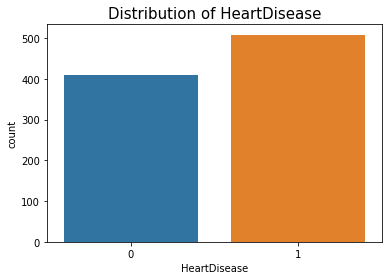

In [3]:
# Load file 
heart_failure_file_path = '/kaggle/input/heart-failure-prediction/heart.csv'
full_data = pd.read_csv(heart_failure_file_path)
#prof = ProfileReport(full_data) # statistics of the features 
#prof.to_file(output_file='output.html')
#full_data.decribe()
#full_data.info()

ax = sns.countplot(data = full_data, x = 'HeartDisease')
ax.set_title(f"Distribution of {'HeartDisease'}", fontsize=15)
    
copy_data = full_data .copy()
y = copy_data['HeartDisease']
X = copy_data.drop(columns='HeartDisease', axis =1)

train_X, valid_X, test_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state=1)


<AxesSubplot:>

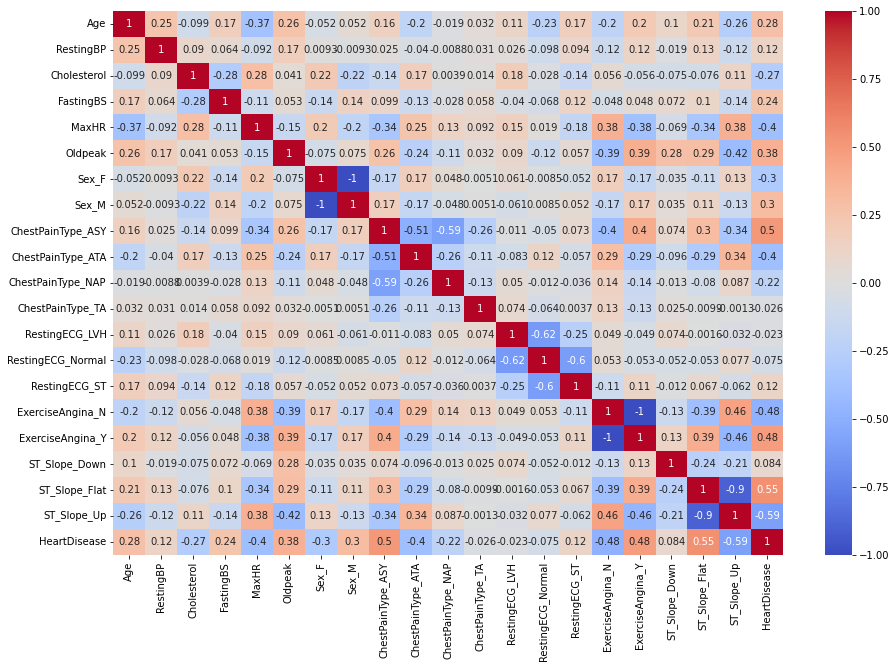

In [4]:
#Create heatmap
dummie_data = pd.get_dummies(train_X,drop_first=False)
dummie_data = pd.concat([dummie_data, test_y], axis =1)
plt.figure(figsize=(15,10))
sns.heatmap(dummie_data.corr(),annot=True,cmap='coolwarm')
#qcut devid to N parts
#target encoder

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


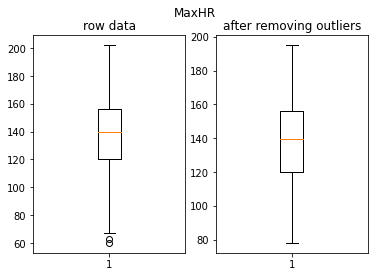

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


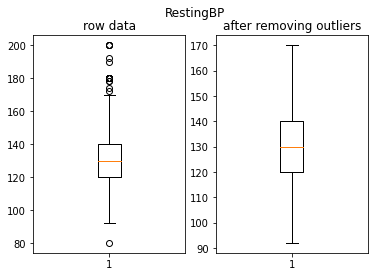

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


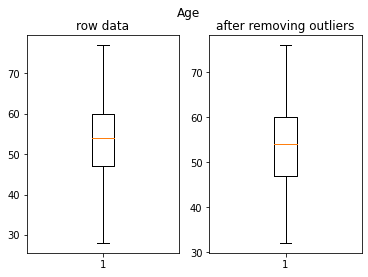

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


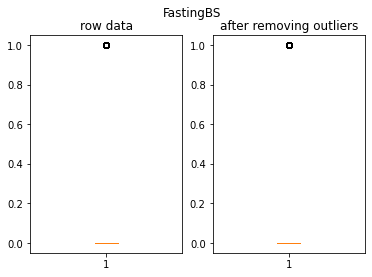

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


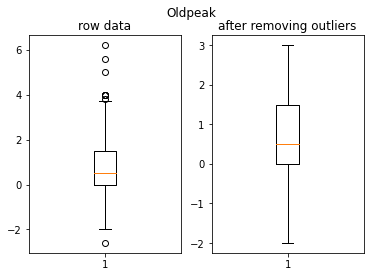

'# Remove data points which are outliers in more than once\nnew_dict = {k:v for k,v in outlier_dict.items() if v}\nmerged = list(itertools.chain.from_iterable(new_dict.values()))\nnum_outliers_dict = Counter(merged)\noutlier_gt_1 = dict((k, v) for k, v in num_outliers_dict.items() if v >= 2)\noutlier_drop_keys = outlier_gt_1.keys()\ntrain_X = train_X.drop(outlier_drop_keys, axis=0)\ntest_y = test_y.drop(outlier_drop_keys, axis=0)'

In [5]:
# check if outliers have same indecise - create dictionary of column and idex of outlier

# Explore data & replace outlieres
columns = list(set(X.select_dtypes(exclude=['object']).columns) - set(["Cholesterol"])) # Remove colesteroal (impute zero values) and RestingBP only one value zero, can be outlier
threshold = 3
outlier_dict = {}
valid_outlier_dict = {}
for col in columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(col)
    ax1.boxplot(train_X[col])
    ax1.set_title('row data')
    (train_X.loc[:, col], train_outlier_ind, valid_X.loc[:, col]) = replace_outlier(train_X[col], valid_X[col], threshold)
    """(train_X.loc[:, col], train_outlier_ind) = replace_outlier(train_X[col], threshold)
    (valid_X.loc[:, col], valid_outlier_ind) = replace_outlier(valid_X[col], threshold)"""
    outlier_dict[col] = train_outlier_ind
    #valid_outlier_dict[col] = valid_outlier_ind
    ax2.boxplot(train_X[col])
    ax2.set_title('after removing outliers')
    plt.show()
    
"""for key in outlier_dict:
    print(str(key) +" "+str(outlier_dict[key]))
for key in valid_outlier_dict:
    print(str(key) +" "+str(valid_outlier_dict[key]))"""

"""# Remove data points which are outliers in more than once
new_dict = {k:v for k,v in outlier_dict.items() if v}
merged = list(itertools.chain.from_iterable(new_dict.values()))
num_outliers_dict = Counter(merged)
outlier_gt_1 = dict((k, v) for k, v in num_outliers_dict.items() if v >= 2)
outlier_drop_keys = outlier_gt_1.keys()
train_X = train_X.drop(outlier_drop_keys, axis=0)
test_y = test_y.drop(outlier_drop_keys, axis=0)"""


In [6]:

obj_col = full_data.select_dtypes(include ='object')


ordinal_label_cols = ['Sex']
OH_label_cols = ['ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina']
drop_label_cols = list(set(train_X.columns) - set(ordinal_label_cols))

ordinal_X_train, ordinal_X_valid = perform_ordinal_encoder(ordinal_label_cols, train_X, valid_X)
OH_X_train, OH_X_valid = perform_OH_encoder(OH_label_cols, train_X, valid_X, obj_col) 

full_X_train = pd.concat([OH_X_train, ordinal_X_train], axis =1)
full_X_valid = pd.concat([OH_X_valid, ordinal_X_valid], axis =1)


full_X_train["HR_gt_100"] = full_X_train["MaxHR"].gt(100)
full_X_valid["HR_gt_100"] = full_X_valid["MaxHR"].gt(100)

full_X_train["Cholesterol_gt_240"] = full_X_train["Cholesterol"].gt(240)
full_X_valid["Cholesterol_gt_240"] = full_X_valid["Cholesterol"].gt(240)

full_X_train["RestingBP_gt_180"] = full_X_train["RestingBP"].gt(180)
full_X_valid["RestingBP_gt_180"] = full_X_valid["RestingBP"].gt(180)

corr_features1 = ["x2_Flat", "x3_Y"]
full_X_train["corr_features1"] = full_X_train[corr_features1].sum(axis=1)
full_X_valid["corr_features1"] = full_X_valid[corr_features1].sum(axis=1)

corr_features2 = ["x0_ASY", "x2_Flat", "x3_Y", "HR_gt_100"]
full_X_train["corr_features2"] = full_X_train[corr_features2].sum(axis=1)
full_X_valid["corr_features2"] = full_X_valid[corr_features2].sum(axis=1)



"""corr_features2 = ["x2_Up", "x3_N"]
full_X_train["corr_features2"] = full_X_train[corr_features2].sum(axis=1)
full_X_valid["corr_features2"] = full_X_valid[corr_features2].sum(axis=1)"""

"""full_X_train["corr_features3"] = full_X_train["Oldpeak"] * (full_X_train["x3_Y"]) * full_X_train["Oldpeak"] 
full_X_valid["corr_features3"] = full_X_valid["Oldpeak"] * (full_X_valid["x3_Y"]) * full_X_valid["Oldpeak"] 

full_X_train["Oldpeak_out_range_0.1"] = ~full_X_train["Oldpeak"].between(-0.1,0.1)
full_X_valid["Oldpeak_out_range_0.1"] = ~full_X_valid["Oldpeak"].between(-0.1,0.1)"""
"""
chest_pain_risk_factors = ['x0_ATA', 'x0_NAP', 'x0_TA']

risk_factors = ["HR_gt_100", "RestingBP_gt_180", "Cholesterol_gt_240"]
full_X_train["risk_factors"] = full_X_train[risk_factors].sum(axis=1)
full_X_valid["risk_factors"] = full_X_valid[risk_factors].sum(axis=1)
"""
"""heart_features = ["HR_gt_100", "x2_Flat"]
BP_features = ["RestingBP_gt_180", "FastingBS"]
Angina_features = ['x0_ASY', "ExerciseAngina"]

full_X_train["heart_features"] = full_X_train[heart_features].sum(axis=1)
full_X_valid["heart_features"] = full_X_valid[heart_features].sum(axis=1)

full_X_train["BP_features"] = full_X_train[BP_features].sum(axis=1)
full_X_valid["BP_features"] = full_X_valid[BP_features].sum(axis=1)
"""
"""Angina_features = ['x0_ASY', "x3_Y"]
full_X_train["Angina_features"] = full_X_train[Angina_features].sum(axis=1)
full_X_valid["Angina_features"] = full_X_valid[Angina_features].sum(axis=1)"""


labels = ['Cholesterol'] 
imputed_X_train, imputed_X_valid = perform_imputation(labels, full_X_train, full_X_valid, 'mean')
train_X_features = imputed_X_train
valid_X_features = imputed_X_valid
"""
top_features = ["x2_Flat", "ExerciseAngina", "x0_ASY", "Oldpeak"]
train_X_features[features] = imputed_X_train[features]
valid_X_features[features] = imputed_X_valid[features]

train_X_features["top_features"] = imputed_X_train[features].sum(axis=1)
valid_X_features["top_features"] = imputed_X_valid[features].sum(axis=1)

low_corr_features = ["RestingBP", 'x1_LVH', 'x1_Normal', 'x1_ST', 'x0_TA']
#train_X_features = train_X_features.drop(low_corr_features, axis=1)
#valid_X_features = valid_X_features.drop(low_corr_features, axis=1)


scaler = MinMaxScaler()
train_X_features = scaler.fit_transform(train_X_features)
valid_X_features = scaler.transform(valid_X_features)


kmeans = KMeans(n_clusters=10, n_init=10)
train_X_features["Cluster"] = kmeans.fit_predict(train_X_features)
imputed_X_train["Cluster"] = imputed_X_train["Cluster"].astype("category")


sns.relplot(x="ExerciseAngina", y="Cholesterol", hue="Cluster", data=imputed_X_train, height=10);
# How to define complex pipeline, both imputation, and encoder -> then do croos_validation
"""


'\ntop_features = ["x2_Flat", "ExerciseAngina", "x0_ASY", "Oldpeak"]\ntrain_X_features[features] = imputed_X_train[features]\nvalid_X_features[features] = imputed_X_valid[features]\n\ntrain_X_features["top_features"] = imputed_X_train[features].sum(axis=1)\nvalid_X_features["top_features"] = imputed_X_valid[features].sum(axis=1)\n\nlow_corr_features = ["RestingBP", \'x1_LVH\', \'x1_Normal\', \'x1_ST\', \'x0_TA\']\n#train_X_features = train_X_features.drop(low_corr_features, axis=1)\n#valid_X_features = valid_X_features.drop(low_corr_features, axis=1)\n\n\nscaler = MinMaxScaler()\ntrain_X_features = scaler.fit_transform(train_X_features)\nvalid_X_features = scaler.transform(valid_X_features)\n\n\nkmeans = KMeans(n_clusters=10, n_init=10)\ntrain_X_features["Cluster"] = kmeans.fit_predict(train_X_features)\nimputed_X_train["Cluster"] = imputed_X_train["Cluster"].astype("category")\n\n\nsns.relplot(x="ExerciseAngina", y="Cholesterol", hue="Cluster", data=imputed_X_train, height=10);\n# How

In [7]:
#Gridsearch
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X_features, test_y)

"""model = RandomForestClassifier(n_estimators=1000, random_state=1) #XGBClassifier() #Add CV to choose estimators, show that tried more models models from different families logistic regression
model.fit(train_X_features, test_y)
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=train_X_features.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)"""
#preds = model.predict(valid_X_features)
print(rf_random.best_params_) #{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
preds = rf_random.predict(valid_X_features)
print("MSE: " + str(mean_absolute_error(valid_y, preds)))
print("recall: " + str(recall_score(valid_y, preds)))
print("precision: " + str(precision_score(valid_y, preds)))
# show matrix of 0 and 1
"""fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()"""


"""
remove_preds = [ "x0_ATA", "x0_NAP", "x0_TA", "x1_LVH", "x1_Normal", "x1_ST", "x2_Down"]
train_X_features = train_X_features.drop(remove_preds, axis=1)
valid_X_features = valid_X_features.drop(remove_preds, axis=1)
new_model = RandomForestClassifier(n_estimators=1000, random_state=0) 
new_model.fit(train_X_features, test_y)
preds = new_model.predict(valid_X_features)
print(mean_absolute_error(valid_y, preds))
print(recall_score(valid_y, preds))
print(precision_score(valid_y, preds))
"""

"""
baseline results - no manipulations to features:
MSE: 0.10326086956521739
recall: 0.9181818181818182
precision: 0.9099099099099099

"""
"""
Baseline + MaxHR>100
MSE: 0.09782608695652174
recall: 0.9272727272727272
precision: 0.9107142857142857
"""
"""
Baseline + MaxHR>100, Cholesterol>240, RestingBP>180
MSE: 0.09239130434782608
recall: 0.9272727272727272
precision: 0.918918918918919"""

"""
Baseline + MaxHR>100, Cholesterol>240, RestingBP>180 + corr:ST_Flat&exerciseAngina_Y
MSE: 0.08695652173913043
recall: 0.9272727272727272
precision: 0.9272727272727272"""

"""
Baseline + MaxHR>100, Cholesterol>240, RestingBP>180 + corr:ST_Flat&exerciseAngina_Y + corr:feat1&HR>100&ASY
MSE: 0.08152173913043478
recall: 0.9363636363636364
precision: 0.9279279279279279"""



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.4s


[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   5.8s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   3.0s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   4.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   1.9s
[CV] n_estimators=1000, mi

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min



[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   5.7s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   2.9s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   1.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   4.8s
[CV] n_estimators=200

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
MSE: 0.08152173913043478
recall: 0.9272727272727272
precision: 0.9357798165137615


'\nBaseline + MaxHR>100, Cholesterol>240, RestingBP>180 + corr:ST_Flat&exerciseAngina_Y + corr:feat1&HR>100&ASY\nMSE: 0.08152173913043478\nrecall: 0.9363636363636364\nprecision: 0.9279279279279279'

In [8]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
# {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
# {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 85, 90, 95],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [1200, 1400, 1600, 1800]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(train_X_features, test_y)
print(grid_search.best_params_) 
preds = grid_search.predict(valid_X_features)
print("MSE: " + str(mean_absolute_error(valid_y, preds)))
print("recall: " + str(recall_score(valid_y, preds)))
print("precision: " + str(precision_score(valid_y, preds)))

confusion_matrix(valid_y, preds)

"""{'bootstrap': True, 'max_depth': 85, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1200}
MSE: 0.08695652173913043
recall: 0.9272727272727272
precision: 0.9272727272727272"""

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.5s



[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   1.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   4.5s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   2.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   4.9s
[CV] n_estimators=8

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min



[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=1800 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=1800, total=   5.2s
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1200 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1200, total=   3.4s
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1400 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1400, total=   4.0s
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1600 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=1600, total=   4.6s
[CV] bootstrap=True, max_de

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.5min



[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200, total=   3.5s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1400 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1400, total=   4.1s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600, total=   4.7s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   4.0s
[CV] bootstrap=True, max_de

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  7.8min finished


{'bootstrap': True, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1400}
MSE: 0.08695652173913043
recall: 0.9272727272727272
precision: 0.9272727272727272


"{'bootstrap': True, 'max_depth': 85, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1200}\nMSE: 0.08695652173913043\nrecall: 0.9272727272727272\nprecision: 0.9272727272727272"